# Review of the Keras API using the Sequential model and Functional API
* Notes from Deep Learning with Python by Francois Chollet
* Refactor code to build same model but using the Keras functional API

## Simple feed-forward neural network using _Sequential_ model

In [63]:
import numpy as np

from keras.datasets import reuters
from keras import models
from keras import layers

import matplotlib.pyplot as plt

In [49]:
# load data
# restrict to 10,000 most frequentyly occuring words in data
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

# train_data contains an array of lists where each list contains the word index for a given Reuters newswire

### Prepare data

In [50]:
def vectorize_sequences(sequences, dimension=10000):
    # turn the list of word indices into a 10000-dimensional
    # 0/1 vector
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        # in position indicated in sequence, replace it 1
        results[i, sequence] = 1.
        
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)
x_train.shape

(8982, 10000)

In [51]:
def to_one_hot(labels, dimension=46):
    # one-hot encode labels (there are 46 labels)
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

one_hot_train_labels = to_one_hot(train_labels)
one_hot_test_labels = to_one_hot(test_labels)

### Build Sequential model and compile it
* This network has one hidden layer with 64 activation units
* The input shape refers to the dimension of a single example. In this case, it is 10,000 words.
* _Dense_ method means we are building a fully connected network
* The first arguement (e.g. 64) in the _Dense_ method refers to the number of units in a given hidden layer
* _relu_ stands for rectified linear unit. It is the activation function applied to the signal
* Given one-hot encoded labels, we use the categorical cross entropy as the loss function we minimize
* The _softmax_ in the final layer gives us a probability distribution over the 46 possible classifications

In [88]:
model = models.Sequential()  # initialize a Sequential model class instance
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 64)                640064    
_________________________________________________________________
dense_17 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_18 (Dense)             (None, 46)                2990      
Total params: 647,214
Trainable params: 647,214
Non-trainable params: 0
_________________________________________________________________


In [91]:
dir(model)
model.layers

### Create validation set and train model

In [70]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

In [71]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=9,  # before setting this to 9, we trained to overfit to determine stopping point
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=0)

### Visualize training and validation loss

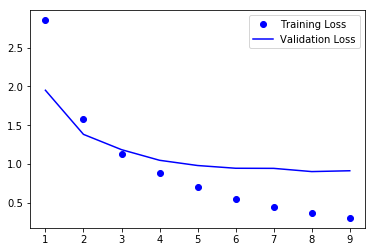

In [82]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) +  1)

plt.plot(epochs, loss, 'bo', label='Training Loss');
plt.plot(epochs, val_loss, 'b', label='Validation Loss');
plt.legend();

In [73]:
results = model.evaluate(x_test, one_hot_test_labels)

2246/2246 [==============================] - 0s 143us/step


In [85]:
print("Model testing accuracy:", results[1])

Model testing accuracy: 0.7920747996703493


In [84]:
# accuracy for random baseline
import copy
test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
hits_array = np.array(test_labels) == np.array(test_labels_copy)
print("Random baseline accuracy:", float(np.sum(hits_array)) / len(test_labels))

Random baseline accuracy: 0.19634906500445237


## Build same model using Functional API
Why is the Functional API useful?
* Sequential model allows only for a linear stack of layers
* It assumes that the network has exactly one input and exactly one output
* The Functional API allows for greater flexibility
    * Multimodal inputs: merging data from different input sources
    * Multimodal output: same input but predict two different types of output
    * Non-linear network topologies
    
   
How is it different from the Sequential model?
* Manipulate tensors directly (instead of an attribute of an instance of the Sequential class)
* Layers are functions that take and returns tensors


In [103]:
from keras import Input, layers

input_tensor = Input(shape=(10000,))
hidden_layer_1 = layers.Dense(64, activation='relu')(input_tensor)
hidden_layer_2 = layers.Dense(64, activation='relu')(hidden_layer_1)
output_tensor = layers.Dense(46, activation='softmax')(hidden_layer_2)

# build network
model_func = Model(input_tensor, output_tensor)

model_func.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

model_func.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 10000)             0         
_________________________________________________________________
dense_41 (Dense)             (None, 64)                640064    
_________________________________________________________________
dense_42 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_43 (Dense)             (None, 46)                2990      
Total params: 647,214
Trainable params: 647,214
Non-trainable params: 0
_________________________________________________________________


In [104]:
# fitting the model is the same process
history_func = model_func.fit(partial_x_train,
                    partial_y_train,
                    epochs=9,  # before setting this to 9, we trained to overfit to determine stopping point
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=0)
results_func = model_func.evaluate(x_test, one_hot_test_labels)
print("Accuracy of same model but build using Functional API", results_func[1])

2246/2246 [==============================] - 0s 102us/step
Accuracy of same model but build using Functional API 0.7943009795191451
